# ***תרגיל 5 של הפרוייקט***

**Load Data and Basic Setup**

In [16]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Extract text and difficulty levels
texts = df["question"].astype(str).tolist()
levels = df["level"].tolist()


**Balancing Dataset (Undersampling to Minority Class)**

In [17]:
# import pandas as pd

# # 1. נגדיר את גודל היעד לפי המחלקה הקטנה ביותר (Hard)
# target_size = 15657

# # 2. נבצע דגימה מכל מחלקה בנפרד
# df_hard = df[df['level'] == 'hard']
# # כאן אנחנו לא עושים sample כי זה כבר הגודל שאנחנו רוצים

# df_medium_downsampled = df[df['level'] == 'medium'].sample(n=target_size, random_state=42)
# df_easy_downsampled = df[df['level'] == 'easy'].sample(n=target_size, random_state=42)

# # 3. נחבר את שלושתן יחד
# df_balanced = pd.concat([df_hard, df_medium_downsampled, df_easy_downsampled])

# # 4. נערבב את הדאטה (חשוב מאוד!)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # בדיקת תוצאה
# print("התפלגות חדשה:")
# print(df_balanced['level'].value_counts())

In [18]:
import pandas as pd

# 1. הגדרת גודל המדגם לכל קטגוריה (היפר-פרמטר של שלב הניסויים)
# התחלה עם 1000 מכל אחת עוזרת לבדיקה מהירה ("מתחילים בקטן" לפי ההוראות)
target_size = 1000

# 2. דגימה מאוזנת מכל הקטגוריות בבת אחת
# groupby מבטיח שנתייחס לכל רמת קושי בנפרד
df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)

# 3. ערבוב הדאטה (Shuffle) - קריטי בלמידה עמוקה!
# כדי שה-Batch לא יכיל רק מחלקה אחת בזמן האימון, מה שיהרוס את הלמידה
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התפלגות כפי שנדרש בשלב ה-EDA ובניתוח הדאטה
print("התפלגות חדשה ומאוזנת:")
print(df_balanced['level'].value_counts())

התפלגות חדשה ומאוזנת:
level
hard      1000
easy      1000
medium    1000
Name: count, dtype: int64


/tmp/ipython-input-1695072842.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)


# **שלב 1**

# **א**

**Choosing Maximum Sequence Length (Documentation)**

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# 1. הגדרת פרמטרים
VOCAB_SIZE = 20000

# 2. אתחול הטוקנייזר (יצירת האובייקט שהיה חסר)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

# 3. חילוץ הטקסטים מהדאטה המאוזן (ודא ששם העמודה נכון, נניח 'text')
texts = df_balanced['question'].astype(str).tolist()

# 4. התאמת הטוקנייזר על הטקסטים (שלב קריטי!)
tokenizer.fit_on_texts(texts)

# 5. המרה לרצפים של מספרים
sequences = tokenizer.texts_to_sequences(texts)

# עכשיו הסטטיסטיקות שלך יעבדו:
sequence_lengths = [len(seq) for seq in sequences]
avg_len = np.mean(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)

print("Average sequence length:", round(avg_len, 2))
print("95th percentile length:", percentile_95)
print("Vocabulary size (actual):", len(tokenizer.word_index))

Average sequence length: 19.18
95th percentile length: 42.0
Vocabulary size (actual): 10598


**Padding and Truncation**

In [20]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. הגדרת המילון (למקרה שלא הוגדר בתא הזה)
label_dict = {'easy': 0, 'medium': 1, 'hard': 2}

# 2. קביעת אורך הרצף
MAX_SEQUENCE_LENGTH = int(percentile_95)

# 3. יצירת X (Padding)
X = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding="post",
    truncating="post"
)

# 4. יצירת y (הפיכת הקטגוריות למטריצה של 0 ו-1)
y_integers = df_balanced['level'].map(label_dict).values
y = to_categorical(y_integers, num_classes=3)

print(f"Data is ready! X shape: {X.shape}, y shape: {y.shape}")

Data is ready! X shape: (3000, 42), y shape: (3000, 3)


# **ב**

**ניסוי 1**


**Embedding Layer מאומן מאפס**

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# --- 1. הגדרת ארכיטקטורת המודל (בדיוק כמו ה-Keras שהיה לנו) ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # ב-LSTM אנחנו לוקחים את ה-hidden state האחרון
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

# --- 2. הכנת הנתונים (הפיכה מ-NumPy ל-PyTorch Tensors) ---
# נשתמש ב-y_integers (מספרים 0,1,2) ולא ב-y (מטריצה), כי PyTorch מעדיף ככה
X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y_integers, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# --- 3. יצירת המודל, האופטימייזר וה-Loss ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(VOCAB_SIZE, 100, 64, 3).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# --- 4. לולאת האימון (עם ה-print שביקשת) ---
epochs = 10
print("Starting training (PyTorch version)...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # חישוב דיוק על ה-Validation (בדיוק כמו ב-Keras)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} "
          f"━━━━━━━━━━━━━━━━━━━━ "
          f"loss: {running_loss/len(train_loader):.4f} - "
          f"acc: {100.*correct/total:.2f}% - "
          f"val_acc: {100.*val_correct/val_total:.2f}%")

Starting training (PyTorch version)...
Epoch 1/10 ━━━━━━━━━━━━━━━━━━━━ loss: 1.0948 - acc: 37.12% - val_acc: 37.50%
Epoch 2/10 ━━━━━━━━━━━━━━━━━━━━ loss: 1.0038 - acc: 42.25% - val_acc: 44.50%
Epoch 3/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9854 - acc: 43.54% - val_acc: 43.00%
Epoch 4/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9762 - acc: 46.25% - val_acc: 44.00%
Epoch 5/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9689 - acc: 46.83% - val_acc: 42.50%
Epoch 6/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9603 - acc: 45.71% - val_acc: 44.00%
Epoch 7/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.9076 - acc: 50.83% - val_acc: 45.50%
Epoch 8/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.8499 - acc: 55.00% - val_acc: 45.67%
Epoch 9/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.7692 - acc: 58.67% - val_acc: 46.83%
Epoch 10/10 ━━━━━━━━━━━━━━━━━━━━ loss: 0.6958 - acc: 63.42% - val_acc: 45.83%


**dounload GloVe**

In [ ]:
# הורדת קובץ ה-GloVe (זה עשוי לקחת דקה-שתיים)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

**Creating the Embedding Matrix from GloVe**

In [23]:
import numpy as np
import torch

def create_embedding_matrix(word_index, vocab_size, embedding_dim=100):
    # 1. טעינת הוקטורים מהקובץ
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # 2. בניית המטריצה עבור ה-Vocab שלנו
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                # מילים שלא נמצאו יקבלו וקטור רנדומלי (או אפסים)
                embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)

# יצירת המטריצה
embedding_weights = create_embedding_matrix(tokenizer.word_index, VOCAB_SIZE)

**Building the model in PyTorch with Frozen/Fine-tuned support**

In [24]:
import torch.nn as nn

class GloVeLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, weights, freeze=True):
        super(GloVeLSTMModel, self).__init__()

        # טעינת המשקולות של GloVe
        # ה-parameter 'freeze' קובע אם המודל יעדכן את הוקטורים (Fine-tune) או לא (Frozen)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=freeze)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

**The Frozen model**

In [25]:
model_frozen = GloVeLSTMModel(VOCAB_SIZE, 100, 64, 3, embedding_weights, freeze=True).to(device)
# כאן תבוא לולאת האימון (אותה לולאה שכתבנו קודם)
print("Training Frozen GloVe Model...")
# train_model(model_frozen, train_loader)

Training Frozen GloVe Model...


**Fine-tuned**

In [26]:
# model_finetune = GloVeLSTMModel(VOCAB_SIZE, 100, 64, 3, embedding_weights, freeze=False).to(device)
# print("Training Fine-tuned GloVe Model...")
# # train_model(model_finetune, train_loader)

# **שלב 2**

**Basic Settings**

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# סעיף א: ארכיטקטורת המודל [cite: 53]
class FlexibleModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
                 model_type='LSTM', bidirectional=False, dropout=0.3, embedding_matrix=None):
        super(FlexibleModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = False # הקפאת Embeddings [cite: 49]

        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True,
                               bidirectional=bidirectional, dropout=dropout if n_layers > 1 else 0)

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)
        self.dropout = nn.Dropout(dropout) # למניעת Overfitting [cite: 66]

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if isinstance(hidden, tuple): hidden = hidden[0]
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        return self.fc(hidden)

# סעיף ב: תהליך האימון - כולל שמירת היסטוריה מלאה [cite: 61, 64]
def run_experiment(model, train_loader, val_loader, epochs=5, lr=0.001):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # שלב האימון
        model.train()
        total_train_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # שלב הולידציה - חישוב Loss ודיוק [cite: 65]
        model.eval()
        total_val_loss = 0
        correct = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        acc = correct / len(val_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")

    return history

# סעיף ג: הערכת ביצועים [cite: 68]
def print_evaluation_section_c(model, loader):
    print("\n" + "="*30)
    print("סעיף ג: הערכת ביצועים")
    print("="*30)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # מדדי Accuracy, Precision, Recall, F1 [cite: 74]
    print(classification_report(all_labels, all_preds, target_names=['Easy', 'Medium', 'Hard']))

    # מטריצת בלבול [cite: 76]
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Easy', 'Medium', 'Hard'], yticklabels=['Easy', 'Medium', 'Hard'])
    plt.title("Confusion Matrix")
    plt.show()

# פונקציה להצגת הגרפים הנדרשים (Loss ו-Accuracy) [cite: 65, 75]
def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # גרף Loss - המקביל המדויק לאיור בעמוד 3 [cite: 70-73]
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss (Error) Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # גרף Accuracy [cite: 75]
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'g-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

**RNN - Regular embedding**

מתחיל ניסוי: RNN, Bidirectional=False
Epoch 1: Train Loss: 1.1158, Val Loss: 1.1031, Val Acc: 0.3633
Epoch 2: Train Loss: 1.0753, Val Loss: 1.0949, Val Acc: 0.3500
Epoch 3: Train Loss: 1.0609, Val Loss: 1.0582, Val Acc: 0.3900
Epoch 4: Train Loss: 1.0350, Val Loss: 1.0195, Val Acc: 0.4083
Epoch 5: Train Loss: 1.0746, Val Loss: 1.0820, Val Acc: 0.3550

סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.96      0.11      0.19       212
      Medium       0.33      0.99      0.50       191
        Hard       0.00      0.00      0.00       197

    accuracy                           0.35       600
   macro avg       0.43      0.37      0.23       600
weighted avg       0.44      0.35      0.23       600



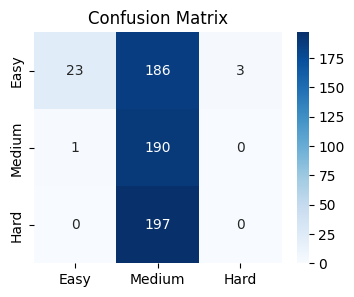

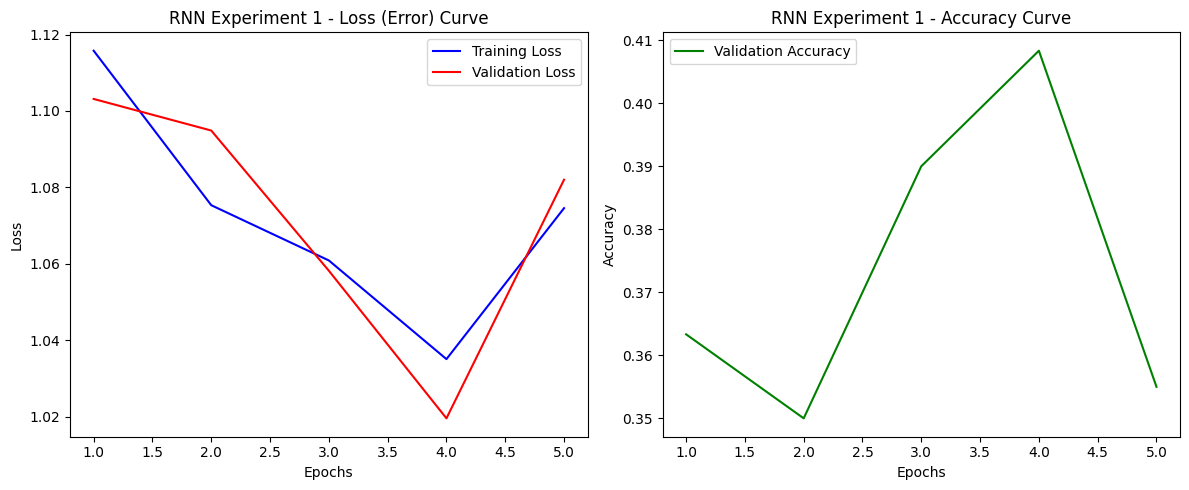


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.96      0.11      0.19       212
      Medium       0.33      0.99      0.50       191
        Hard       0.00      0.00      0.00       197

    accuracy                           0.35       600
   macro avg       0.43      0.37      0.23       600
weighted avg       0.44      0.35      0.23       600



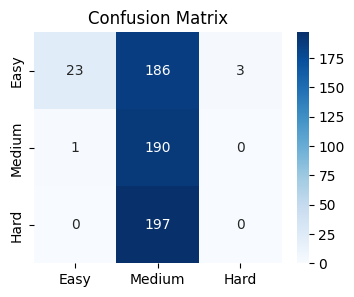

In [39]:
# הגדרות ספציפיות לניסוי
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
EMBED_MAT = None # מאומן מאפס

# א. הגדרת המודל
model_1 = FlexibleModel(10599, 100, 128, 3, n_layers=1,
                        model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)

# ב. אימון המודל
print(f"מתחיל ניסוי: {MODEL_TYPE}, Bidirectional={IS_BIDIRECTIONAL}")
history_1 = run_experiment(model_1, train_loader, val_loader, epochs=5)

# ג. הערכת ביצועים
print_evaluation_section_c(model_1, val_loader)


# הדפסת הגרף של סעיף ב.2
plot_training_history(history_1, model_name="RNN Experiment 1")

# הדפסת הערכת הביצועים של סעיף ג'
print_evaluation_section_c(model_1, val_loader)

**RNN - GloVe frozen**

מתחיל ניסוי 2: RNN, Embedding=GloVe Frozen
Epoch 1: Train Loss: 1.0149, Val Loss: 1.0055, Val Acc: 0.4333


/tmp/ipython-input-1411159259.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


Epoch 2: Train Loss: 0.9947, Val Loss: 1.0010, Val Acc: 0.4367
Epoch 3: Train Loss: 0.9884, Val Loss: 0.9989, Val Acc: 0.4467
Epoch 4: Train Loss: 0.9910, Val Loss: 1.0057, Val Acc: 0.4383
Epoch 5: Train Loss: 0.9837, Val Loss: 0.9948, Val Acc: 0.4517


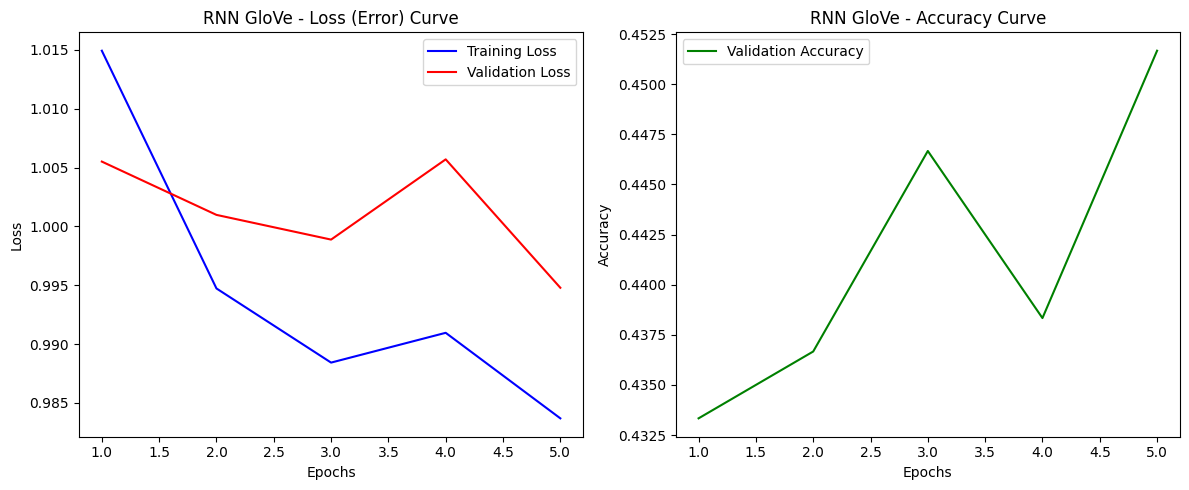


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.82      0.39      0.53       212
      Medium       0.00      0.00      0.00       191
        Hard       0.38      0.96      0.54       197

    accuracy                           0.45       600
   macro avg       0.40      0.45      0.36       600
weighted avg       0.41      0.45      0.36       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


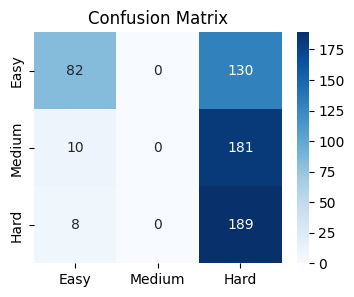

In [40]:
# ניסוי 2: RNN + GloVe (Frozen)
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
EMBED_MAT = embedding_weights # וודאו שמשתנה זה הוגדר בשלב ה-Embedding

print(f"מתחיל ניסוי 2: {MODEL_TYPE}, Embedding=GloVe Frozen")
model_2 = FlexibleModel(10599, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
history_2 = run_experiment(model_2, train_loader, val_loader, epochs=5)

plot_training_history(history_2, model_name="RNN GloVe")
print_evaluation_section_c(model_2, val_loader)

**LSTM - Regular embedding**

מתחיל ניסוי 3: LSTM, Embedding=Scratch
Epoch 1: Train Loss: 1.0717, Val Loss: 0.9909, Val Acc: 0.4417
Epoch 2: Train Loss: 0.9871, Val Loss: 1.0009, Val Acc: 0.4400
Epoch 3: Train Loss: 0.9784, Val Loss: 0.9999, Val Acc: 0.4550
Epoch 4: Train Loss: 0.9734, Val Loss: 0.9894, Val Acc: 0.4450
Epoch 5: Train Loss: 0.9572, Val Loss: 1.0542, Val Acc: 0.4033


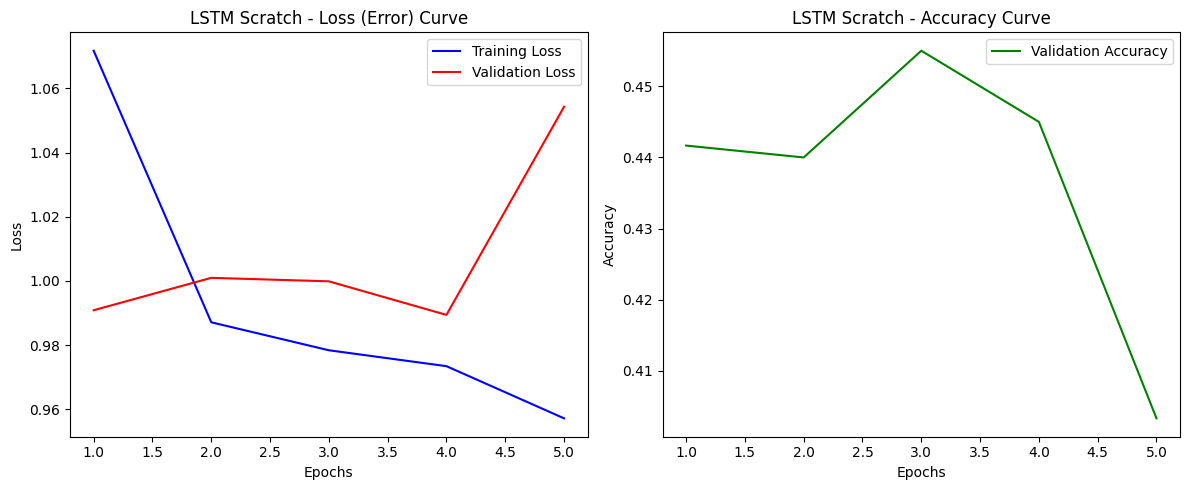


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.93      0.25      0.40       212
      Medium       0.35      0.98      0.51       191
        Hard       0.00      0.00      0.00       197

    accuracy                           0.40       600
   macro avg       0.43      0.41      0.30       600
weighted avg       0.44      0.40      0.30       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


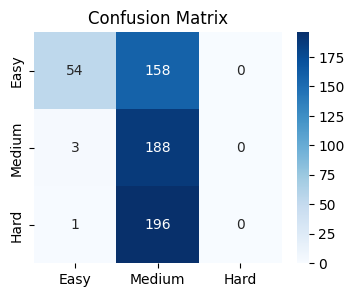

In [41]:
# ניסוי 3: LSTM + Trained from scratch
MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = None

print(f"מתחיל ניסוי 3: {MODEL_TYPE}, Embedding=Scratch")
model_3 = FlexibleModel(10599, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
history_3 = run_experiment(model_3, train_loader, val_loader, epochs=5)

plot_training_history(history_3, model_name="LSTM Scratch")
print_evaluation_section_c(model_3, val_loader)

**LSTM - GloVe frozen**

מתחיל ניסוי 4: LSTM, Embedding=GloVe Frozen


/tmp/ipython-input-1411159259.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


Epoch 1: Train Loss: 0.9985, Val Loss: 1.0030, Val Acc: 0.4317
Epoch 2: Train Loss: 0.9815, Val Loss: 0.9913, Val Acc: 0.4367
Epoch 3: Train Loss: 0.9771, Val Loss: 0.9914, Val Acc: 0.4400
Epoch 4: Train Loss: 0.9773, Val Loss: 0.9886, Val Acc: 0.4433
Epoch 5: Train Loss: 0.9757, Val Loss: 0.9902, Val Acc: 0.4517


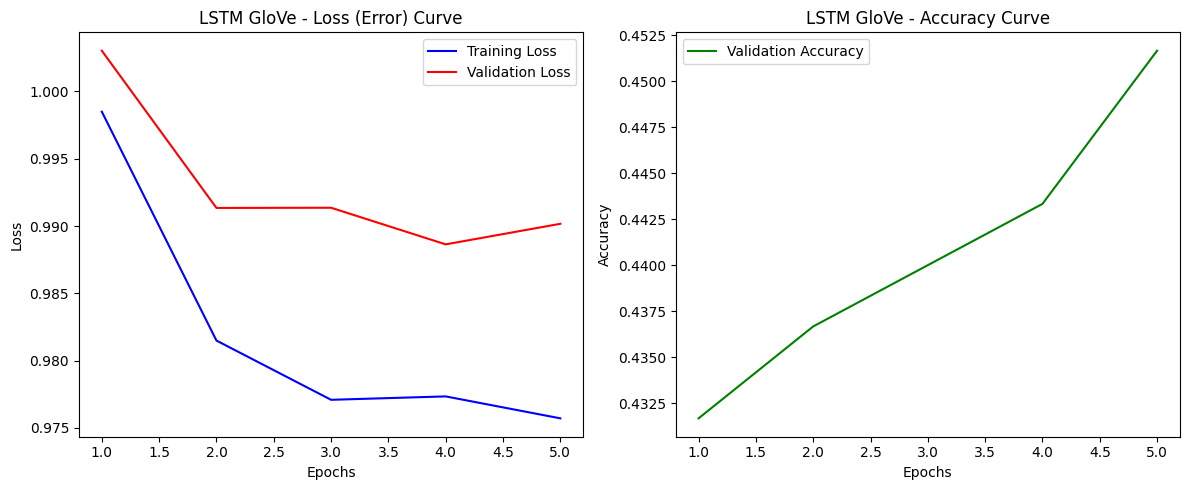


סעיף ג: הערכת ביצועים
              precision    recall  f1-score   support

        Easy       0.73      0.46      0.57       212
      Medium       0.37      0.91      0.53       191
        Hard       0.00      0.00      0.00       197

    accuracy                           0.45       600
   macro avg       0.37      0.46      0.36       600
weighted avg       0.38      0.45      0.37       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


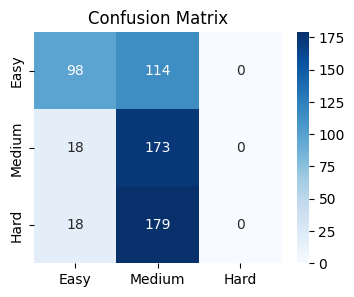

In [42]:
# ניסוי 4: LSTM + GloVe (Frozen)
MODEL_TYPE = 'LSTM'
IS_BIDIRECTIONAL = False
EMBED_MAT = embedding_weights

print(f"מתחיל ניסוי 4: {MODEL_TYPE}, Embedding=GloVe Frozen")
model_4 = FlexibleModel(10599, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
history_4 = run_experiment(model_4, train_loader, val_loader, epochs=5)

plot_training_history(history_4, model_name="LSTM GloVe")
print_evaluation_section_c(model_4, val_loader)

**BiLSTM - regular embedding**

In [ ]:
# # ניסוי 5: BiLSTM + Trained from scratch
# MODEL_TYPE = 'LSTM'
# IS_BIDIRECTIONAL = True
# EMBED_MAT = None

# print(f"מתחיל ניסוי 5: Bi-directional {MODEL_TYPE}, Embedding=Scratch")
# model_5 = FlexibleModel(10599, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
# history_5 = run_experiment(model_5, train_loader, val_loader, epochs=5)

# plot_training_history(history_5, model_name="BiLSTM Scratch")
# print_evaluation_section_c(model_5, val_loader)

**Frozen BiLSTM - GloVe**

In [ ]:
# # ניסוי 6: BiLSTM + GloVe (Frozen)
# MODEL_TYPE = 'LSTM'
# IS_BIDIRECTIONAL = True
# EMBED_MAT = embedding_weights

# print(f"מתחיל ניסוי 6: Bi-directional {MODEL_TYPE}, Embedding=GloVe Frozen")
# model_6 = FlexibleModel(10599, 100, 128, 3, n_layers=1, model_type=MODEL_TYPE, bidirectional=IS_BIDIRECTIONAL, embedding_matrix=EMBED_MAT)
# history_6 = run_experiment(model_6, train_loader, val_loader, epochs=5)

# plot_training_history(history_6, model_name="BiLSTM GloVe")
# print_evaluation_section_c(model_6, val_loader)